<a href="https://colab.research.google.com/github/ggzone/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter09/Semantic_Segmentation_with_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/MyDrive/mcvp-packt/Chapter09')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [9]:
import os
if not os.path.exists('dataset1'):
    #!wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
    !pip install -q torch_snippets pytorch_model_summary

!pip install -q torch_snippets pytorch_model_summary

import torch
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.9 MB/s eta 0:00:00


In [11]:
#!pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
#import selectivesearch
import torch
from torch.utils.data import Dataset
import cv2
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# by clicking on Create New API token in your personal account
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json
# !C:\Users\hunter\AppData\Roaming\Python\Python312\Scripts\kaggle.exe  datasets download -d sixhky/open-images-bus-trucks/
# !unzip -qq open-images-bus-trucks.zip
from torchvision import transforms, models, datasets
from torch_snippets.torch_loader import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [13]:
class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))
        #mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')  #书中原有代码
        mask = cv2.imread(f'./dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png', cv2.IMREAD_GRAYSCALE)  #勘误
        mask = cv2.resize(mask, (224,224))
        return image, mask
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        print(ce_masks.shape)
        return ims, ce_masks

In [14]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

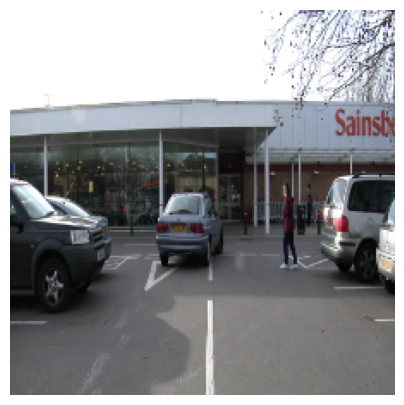

In [15]:
show(trn_ds[10][0])

In [16]:
next(iter(trn_dl))

torch.Size([4, 224, 224])


(tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  0.5707,  1.6153,  1.6495],
           [ 2.2489,  2.2489,  2.2489,  ...,  0.5022,  1.6324,  1.6324],
           [ 2.2489,  2.2489,  2.2489,  ...,  0.3994,  1.6324,  1.6324],
           ...,
           [-1.1932, -1.0562, -1.3130,  ..., -0.6109, -0.6109, -0.5938],
           [-1.3644, -1.2445, -1.1075,  ..., -0.5596, -0.6109, -0.5767],
           [-1.1418, -1.0904, -1.2274,  ..., -0.5596, -0.5938, -0.5424]],
 
          [[ 2.4286,  2.4286,  2.4286,  ...,  0.8529,  2.4286,  2.4286],
           [ 2.4286,  2.4286,  2.4286,  ...,  0.7829,  2.4286,  2.4286],
           [ 2.4286,  2.4286,  2.4286,  ...,  0.6954,  2.4286,  2.4286],
           ...,
           [-1.0203, -0.8627, -1.1078,  ..., -0.4601, -0.4601, -0.4426],
           [-1.1254, -1.0028, -0.8627,  ..., -0.3725, -0.4251, -0.4426],
           [-0.8978, -0.8627, -0.9853,  ..., -0.3725, -0.4076, -0.4076]],
 
          [[ 2.6400,  2.6400,  2.6400,  ...,  1.7337,  2.6400,  2.6400],
           [ 

In [17]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [18]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [19]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [20]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [21]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [22]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:05<00:00, 105MB/s] 


In [23]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        print(data[0].shape)
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)

流式输出内容被截断，只能显示最后 5000 行内容。
EPOCH: 2.804  trn_loss: 0.640  trn_acc: 0.819  (61.72s - 378.44s remaining)torch.Size([4, 224, 224])
torch.Size([4, 3, 224, 224])
EPOCH: 2.815  trn_loss: 0.628  trn_acc: 0.819  (61.92s - 377.98s remaining)torch.Size([4, 224, 224])
torch.Size([4, 3, 224, 224])
EPOCH: 2.826  trn_loss: 0.555  trn_acc: 0.860  (62.14s - 377.60s remaining)torch.Size([4, 224, 224])
torch.Size([4, 3, 224, 224])
EPOCH: 2.837  trn_loss: 0.491  trn_acc: 0.877  (62.34s - 377.16s remaining)torch.Size([4, 224, 224])
torch.Size([4, 3, 224, 224])
EPOCH: 2.848  trn_loss: 0.557  trn_acc: 0.846  (62.55s - 376.72s remaining)torch.Size([4, 224, 224])
torch.Size([4, 3, 224, 224])
EPOCH: 2.859  trn_loss: 0.588  trn_acc: 0.832  (62.75s - 376.26s remaining)torch.Size([4, 224, 224])
torch.Size([4, 3, 224, 224])
EPOCH: 2.870  trn_loss: 0.519  trn_acc: 0.861  (62.95s - 375.82s remaining)torch.Size([4, 224, 224])
torch.Size([4, 3, 224, 224])
EPOCH: 2.880  trn_loss: 0.455  trn_acc: 0.886  (63.18s - 375.48

100%|██████████| 121/121 [00:00<00:00, 1109.83it/s]


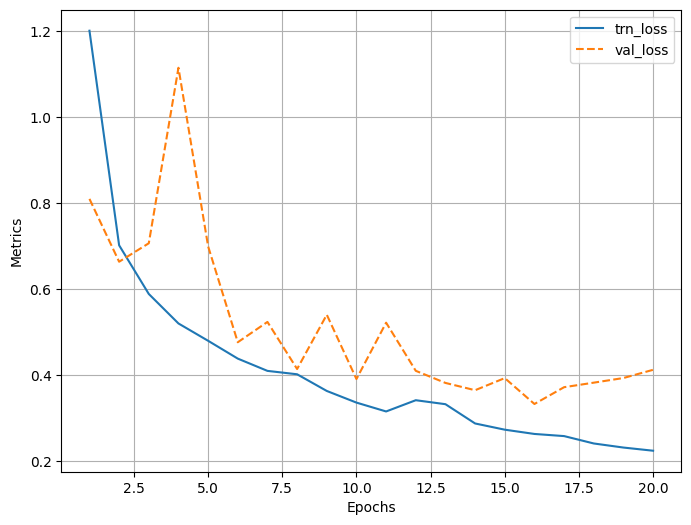

In [24]:
log.plot_epochs(['trn_loss','val_loss'])

torch.Size([1, 224, 224])


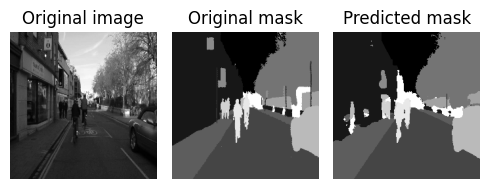

In [31]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])